In [1]:
# Import necessary packages
import pandas as pd
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn import tree
from sklearn.cross_decomposition import PLSRegression
from sklearn import model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
import scipy as sp
import scipy.stats as stats
from statistics import mean

# Set the working directory so that code, data, and figures can be easily accessed
dir_path = os.path.abspath('')
os.chdir(os.path.dirname(dir_path))

database = 'GSE124439_RAW' # Specifies the local directory with the sample data from the GSE124439 database
starterFile = 'GSM3533230_CGND-HRA-00013_counts' # Specifies an arbitrarily chosen file from the GSE124439 database to add the genes DF column

path = ('data' + '/' + database + '/' + starterFile + '.txt') # Specifies the local path to the starterFile
data = pd.read_csv(path, sep = "\s+", header = 0, names = ['genes','counts']) # Reads in the starterFile
df = pd.DataFrame(data['genes']) # Adds the genes column to start a Pandas DataFrame (same for all files)

for filename in os.listdir('data' + '/' + database): # Iterates through each file in the database
    path = ('data' + '/' + database + '/' + filename)
    data = pd.read_csv(path, sep = "\s+", header = 0, names = ['genes','counts'])

    regData = []
    for i in data['counts']:
        regData.append(i)
    
    # Creates a log10-scaled version of the reads data for much easier visualization
    #logData = []
    #for i in data['counts']:
    #    if(i == 0):
    #        logData.append(0)
    #    else:
    #        logData.append(math.log10(i))

    truncName = filename[:-4]
    df[truncName] = pd.DataFrame(regData) # Adds the read counts for the given sample to the DataFrame

geneIndexedDF = df.set_index('genes') # Makes the genes column the index for the DataFrame

sortedDF = geneIndexedDF.sort_values(by=[starterFile],ascending=False) # Sorts reads descending for the starterFile

In [2]:
# SHIFT FROM PCA / PLS-DA TO MANN-WHITNEY & DEG ANALYSIS
df_scale = sortedDF.T #creates copy of the transposed dataframe

#Scales all counts to housekeeper gene Glucose-6-phosphate isomerase
#Eisenberg and Levanon, 2013
for i in df_scale:
    df_scale[i] = df_scale[i]/df_scale['SNRPD3']

#Removes all genes which have more than 50% of samples with 0 counts 
lst = []
for i in df_scale:
    count = 0
    for j in df_scale[i]:
        #print (j)
        if j == 0:
            count += 1
    if count > 0.5*len(i):
        lst.append(i)
df_scale.drop(columns = lst, inplace = True)

#Sorts DataFrame by ID number
df_scale.sort_index(inplace=True)

# Load the data matrix describing what each sample is
matrixPath = ('data/patient_info_matrix.xlsx') # Specifies the local path to the matrix of information
matrixData = pd.read_excel(matrixPath, header=0) # Reads in the starterFile
matrixData.sort_values(by=['RNA-seq ID'])

#Assigns gender adn Disease Group to each sample
df_scale['gender'] = matrixData['Gender'].factorize()[0] # 0 is female, 1 is male
df_scale['group'] = matrixData['Subject Group'].factorize()[0] # 0,2 is ALS, 1 is control, 3 is other nuerological control

#Initializes new dataframes for each demographic group 
df_T = df_scale
df_ALS_male = pd.DataFrame(index=df_T.columns)
df_ALS_female = pd.DataFrame(index=df_T.columns)
df_cont_male = pd.DataFrame(index=df_T.columns)
df_cont_female = pd.DataFrame(index=df_T.columns)

#Populates demographic based dataframes
df = df_T.T
for i in df:
    if df.loc['gender',i] == 1 and (df.loc['group',i] == 1):
        df_cont_male[i] = df[i]
    elif df.loc['gender',i] == 1 and (df.loc['group',i] == 0 or df.loc['group',i] == 2):
        df_ALS_male[i] = df[i]
    elif df.loc['gender',i] == 0 and (df.loc['group',i] == 1):
        df_cont_female[i] = df[i]
    elif df.loc['gender',i] == 0 and (df.loc['group',i] == 0 or df.loc['group',i] == 2):
        df_ALS_female[i] = df[i]
        
#Transposes demographic dataframes for iteration
df_maleALS = df_ALS_male.T
df_femaleALS = df_ALS_female.T
df_maleCont = df_cont_male.T
df_femaleCont = df_cont_female.T

#Creates Disease subgroups 
frames_ALS = [df_maleALS, df_femaleALS]
df_ALS = pd.concat(frames_ALS)
frames_cont = [df_maleCont, df_femaleCont]
df_cont = pd.concat(frames_cont)

#Returns reates p_value and log2 fold increase for each gene
#Compares ALS patient to control patient averages for each gene 
p_values = []
for i in df_ALS.iloc[:,:-2]:
    if df_ALS[i].nunique() != 1 and df_cont[i].nunique() != 1:
        lst1 = df_ALS[i]
        lst2 = df_cont[i]
        p_values.append((i,(stats.ttest_ind(lst1, lst2)[1]), math.log2(mean(lst1)/mean(lst2))))

#Compares male ALS patient to male control patient averages for each gene 
p_values_male = []
for i in df_maleALS.iloc[:,:-2]:
    if df_maleALS[i].nunique() != 1 and df_maleCont[i].nunique() != 1:
        lst1 = df_maleALS[i]
        lst2 = df_maleCont[i]
        p_values_male.append((i,(stats.ttest_ind(lst1, lst2)[1]), math.log2(mean(lst1)/mean(lst2))))
    #else:
    #    print (df_maleALS[i], df_maleCont[i])

#Compares female ALS patient to female control patient averages for each gene 
p_values_female = []
for i in df_femaleALS.iloc[:,:-2]:
    if df_femaleALS[i].nunique() != 1 and df_femaleCont[i].nunique() != 1:
        lst1 = df_femaleALS[i]
        lst2 = df_femaleCont[i]
        p_values_female.append((i,(stats.ttest_ind(lst1, lst2)[1]), math.log2(mean(lst1)/mean(lst2))))

#sorts DEG analyses by p_value
p_sort = sorted(p_values, key=lambda pval: pval[1])
pmale_sort = sorted(p_values_male, key=lambda pval: pval[1])
pfemale_sort = sorted(p_values_female, key=lambda pval: pval[1])

#Determine differentially expressed genes using Bonferroni Correction (Not used in report)
#takes lst of genes with associated p value and returns genes under threshold determined by bonferrroni correction
#alpha = 0.1
def DEG(lst):
    degs = []
    for i in lst:
        if i[1] < 0.10/len(lst):
            degs.append(i[0])
    return degs

print ('ALS:', DEG(p_sort), len(DEG(p_sort)))
print ('Male:', DEG(pmale_sort), len(DEG(pmale_sort)))
print ('Female:', DEG(pfemale_sort), len(DEG(pfemale_sort)))



ALS: ['ATP2A1', 'ANKRD20A9P', 'GNMT', 'ABO', 'ARAP3', 'ADAM8', 'PKD1L3', 'NPEPL1', 'COLEC11', 'LOC100506274', 'GOLGA8A', 'FTH1P3', 'MUC20', 'GBP4', 'HAPLN3', 'NANOGP8', 'CFAP99', 'TCHH', 'GIMAP7', 'SEC31B', 'MIR7161', 'LENG8', 'BEAN1-AS1', 'IGFALS', 'IGSF22', 'LY6G5B'] 26
Male: ['GSTM3', 'CRTC1', 'RERE'] 3
Female: ['COLEC11', 'MGC12916', 'LOC100506274', 'POLR2J2', 'SLC5A4', 'GPR132', 'VSIG8', 'ATP2A1', 'DISP3', 'GBP4', 'CCDC78', 'NPEPL1', 'CFAP73', 'LOC100133091', 'LINC00265', 'HAPLN3', 'DNAH1', 'UPK3BL1', 'ABO', 'ANKRD20A9P'] 20


In [5]:
#may throw error. To resolve try (import statsmodels as sm)
import statsmodels.api as sm

#Takes list of genes (gene, p_val, 2foldchange) and returns adjusted p_value in place of old p_value
#Used Bonferroni_Hachberg correction
def DEF(genes, alpha):
    pvals = []
    for i in genes:
        pvals.append(i[1])
    results = sm.stats.multitest.multipletests(pvals, alpha=alpha,
                                               method='fdr_bh', is_sorted=False, returnsorted=False)
    adj_pval = []
    for i in range(len(genes)):
        adj_pval.append((genes[i][0], results[1][i], genes[i][2], results[0][i]))
    return adj_pval

#Takes list of genes with adjusted p_value and resuturns list of genes found to be differentially expressed
def diff_exp(lst):
    degs = []
    for i in lst:
        if i[3] == True:
            degs.append(i[0])
    return degs

print('DEGs between ALS and control patients:', diff_exp(DEF(p_sort, .1)), len(diff_exp(DEF(p_sort, .1))))
print('DEGs between ALS and control patients in male cohort:', diff_exp(DEF(pmale_sort, .1)), len(diff_exp(DEF(pmale_sort, .1))))
print('DEGs between ALS and control patients in female cohort:', diff_exp(DEF(pfemale_sort, .1)), len(diff_exp(DEF(pfemale_sort, .1))))


DEGs between ALS and control patients: ['ATP2A1', 'ANKRD20A9P', 'GNMT', 'ABO', 'ARAP3', 'ADAM8', 'PKD1L3', 'NPEPL1', 'COLEC11', 'LOC100506274', 'GOLGA8A', 'FTH1P3', 'MUC20', 'GBP4', 'HAPLN3', 'NANOGP8', 'CFAP99', 'TCHH', 'GIMAP7', 'SEC31B', 'MIR7161', 'LENG8', 'BEAN1-AS1', 'IGFALS', 'IGSF22', 'LY6G5B', 'BSR/Beta:Satellite:Satellite', 'SLC5A4', 'DNAH1', 'SNRNP70', 'ZNF534', 'MGC12916', 'RYR1', 'PKD1', 'MOV10', 'SZT2', 'IDUA', 'AKR7L', 'ADGRB1', 'TDRD10', 'C19orf71', 'LINC01572', 'TSPYL2', 'RAP1GAP', 'GOLGA2P5', 'TTLL3', 'PPIP5K1P1-CATSPER2', 'IL1B', 'WDR90', 'PXDN', 'TBC1D26', 'ZMIZ1-AS1', 'MORC2-AS1', 'LGR6', 'ILF3', 'PMFBP1', 'INHA', 'LINC01238', 'PKD1P3-NPIPA1', 'TTC25', 'GLYCTK', 'ITIH4', 'ZZEF1', 'ASIC3', 'AKAP8L', 'CCDC78', 'PCDHB17P', 'CHTF18', 'RTEL1-TNFRSF6B', 'TCF25', 'COL6A4P2', 'ZFR2', 'TARBP1', 'AP1G2', 'GSTM3', 'SST1:centr:Satellite', 'PAPLN', 'LINC00265', 'AQP7P1', 'RTEL1', 'VWCE', 'KANSL3', 'VWF', 'CCDC180', 'MAGED2', 'PABPC1L', 'POFUT2', 'CACNA1B', 'FAM71F1', 'NLRP3', '

In [6]:
#Creates Values for Venn Diagram
ALS = diff_exp(DEF(p_sort, .1))
male = diff_exp(DEF(pmale_sort, .1))
female = diff_exp(DEF(pfemale_sort, .1))

combined = male + female + ALS
combined = list(dict.fromkeys(combined))

group1 = 0 #male, female, ALS
group2 = 0 #male only
group3 = 0 #female only
group4 = 0 #ALS only
group5 = 0 #male, female
group6 = 0 #male, ALS
group7 = 0 #female ALS


for i in combined:
    if i in male and i in female and i in ALS:
        group1 += 1
        print (i) #prints list of genes at intersection of DEG analysis
    elif i in male and i not in female and i not in ALS:
        group2 += 1
    elif i in female and i not in male and i not in ALS:
        group3 += 1
    elif i in ALS and i not in male and i not in female:
        group4 += 1
    elif i in male and i in female and i not in ALS:
        group5 += 1
    elif i in male and i in ALS and i not in female:
        group6 += 1
    elif i in female and i in ALS and i not in male:
        group7 += 1
    
print (group1, group2, group3, group4, group5, group6, group7)

#Genes of interest identified in (Lederer, 2007; Mougeot, 2011; Scoles, 2020)
gois = ["SOD1", "TARDBP", "FUS", "C9orf72", "ATXN2", "TAF15", "UBQLN2", "OPTN", "KIF5A", "hnRNPA1",
        "hnRNPA2 B1","MATR3", "CHCHD10", "EWSR1", "TIA1", "SETX", "ANG", "CCNF", "NEK1", "TBK1", "VCP",
        "SQSTM1", "PFN1", "TUBB4A", "CHMP2B", "SPG11", "ALS2", "TDP43", "SOD1", "Ctss", "Mmp12", "Gpnmb",
        "Trem2", "Cd300c2","Mpeg1", "Hvcn1", "C4b", "Gm23969", "Tyrobp", "Steap1", "Lgals3", "Atp6v0d2", "C3", 
        "Gm6166", "Clic6", "Rgs1", "Ifi202b", "Cd68 ", "Clec7a", "Sspo", "Il1rrn", "Adgrg5",]

#Creates list of GOI in DEG analysis groups for plotting 
gois_ALS = []
for i in DEF(p_sort, .1):
    if i[0] in gois:
        gois_ALS.append(i)
        
gois_male = []
for i in DEF(pmale_sort, .1):
    if i[0] in gois:
        gois_male.append(i)
        
gois_female = []
for i in DEF(pfemale_sort, .1):
    if i[0] in gois:
        gois_female.append(i)

LENG8
SNRNP70
TCF25
SZT2
MUC20
RAP1GAP
ATP2A1
IGFALS
GOLGA8A
GOLGA8B
10 35 350 259 0 92 498


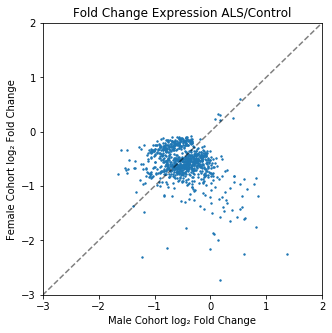

In [7]:
#Plots DEGs from combined group onto plot using log2 Fold Change Expression in Male and Female Cohorts
ALS_pval = DEF(p_sort, .05)
male_pval = DEF(pmale_sort, .1)
female_pval = DEF(pfemale_sort, .1)

dict_male = {}
dict_female = {}
for i in male_pval:
    if i[0] in ALS:
        dict_male[i[0]] = i[2]
    
for i in female_pval:
    if i[0] in ALS:
        dict_female[i[0]] = i[2]

goi_male = {}
goi_female = {}
for i in DEF(pmale_sort, .1):
    if i[0] in gois:
        goi_male[i[0]] = i[2]

for i in DEF(pfemale_sort, .1):
    if i[0] in gois:
        goi_female[i[0]] = i[2]
        
lstx = []
lsty = []
lstC = []
for i in ALS:
    lstx.append(dict_male[i])
    lsty.append(dict_female[i])

plt.figure(figsize=(5,5))
plt.plot([-10, 10], [-10, 10], '--', alpha = 0.5, c = 'black')
plt.scatter(lstx, lsty, s = 2)
plt.ylim([-3, 2])
plt.xlim([-3, 2])
plt.xlabel('Male Cohort log\N{SUBSCRIPT TWO} Fold Change')
plt.ylabel('Female Cohort log\N{SUBSCRIPT TWO} Fold Change')
plt.title('Fold Change Expression ALS/Control')

plt.savefig('figures/DEG_foldchange.pdf')
        

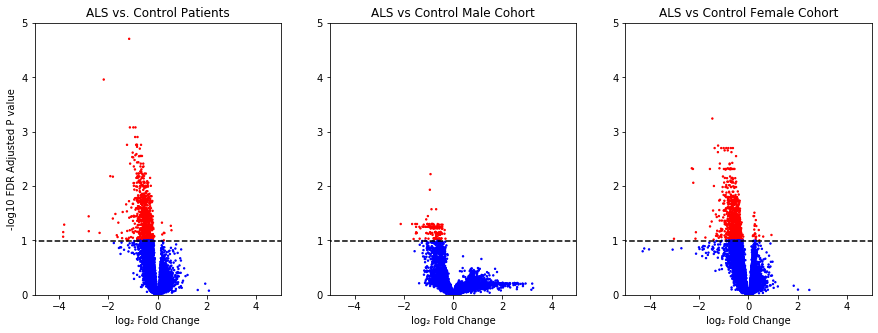

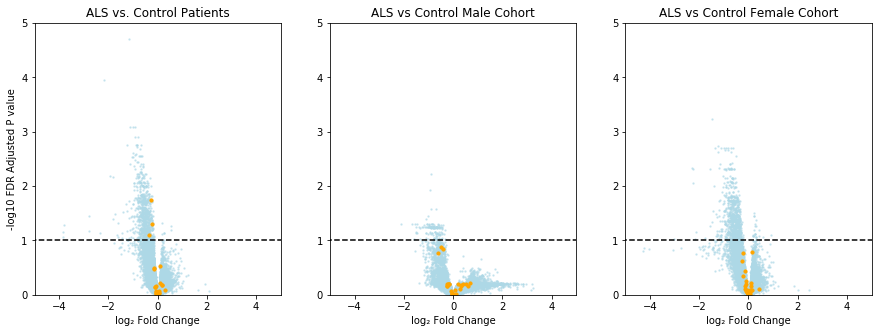

In [8]:
#Returns list of x values (log2 Fold Change Expression) and y values (-log10 p-val) for every gene in sample
#and significance value cut off
def split_pval(lst):
    lstX = []
    lstY = []
    lstC = []
    for i in range(len(lst)):
        lstX.append(lst[i][2])
        lstY.append(-math.log10(lst[i][1]))
        if (lst[i][3]) == True : #This code was suppose to change colors of DEGs but it doesnt work for some reason 
            lstC.append('#ff0000')
        else:
            lstC.append('#0000ff')
    return (lstX, lstY, lstC)

#Volcano Plot for DEGs for 3 analyses, requires lst of genes with associated adjusted p value and fodl change expression
vals = [DEF(p_sort, .1), DEF(pmale_sort, .1), DEF(pfemale_sort, .1), gois_ALS, gois_male, gois_female]
titles = ['ALS vs. Control Patients', 'ALS vs Control Male Cohort', 'ALS vs Control Female Cohort']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for i in range(len(axs)):
    axs[i].scatter(split_pval(vals[i])[0], split_pval(vals[i])[1], s = 2, c = split_pval(vals[i])[2])
    axs[i].plot([-10, 10],[-math.log10(0.101), -math.log10(0.101)], '--', c = 'black')
    axs[i].set_ylim(0,5)
    axs[i].set_xlim(-5,5)
    axs[i].set_xlabel('log\N{SUBSCRIPT TWO} Fold Change')
    axs[0].set_ylabel('-log10 FDR Adjusted P value')
    axs[i].set_title(titles[i])

fig.savefig('figures/VolcanoPlots.pdf')

#Plots all genes on volcano plot, but only highlights 26 GOIs

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(len(axs)):
    axs[i].scatter(split_pval(vals[i])[0], split_pval(vals[i])[1], s = 2, alpha = 0.5, c = 'lightblue')
    axs[i].scatter(split_pval(vals[i+3])[0], split_pval(vals[i+3])[1], s = 10, c = 'orange')
    axs[i].plot([-10, 10],[-math.log10(0.1), -math.log10(0.1)], '--', c = 'black')
    axs[i].set_ylim(0,5)
    axs[i].set_xlim(-5,5)
    axs[i].set_xlabel('log\N{SUBSCRIPT TWO} Fold Change')
    axs[0].set_ylabel('-log10 FDR Adjusted P value')
    axs[i].set_title(titles[i])

fig.savefig('figures/VolcanoPlots_grayed.pdf')